In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path+= ["../"]
from ResonanceEquationsOfMotions import ResonanceEquations


import rebound as rb

from ResonanceEquationsOfMotions import getOmegaMatrix
res_eqs = ResonanceEquations(5,2,n_quad_pts=51)

from ResonantRV_Utils import acr_function

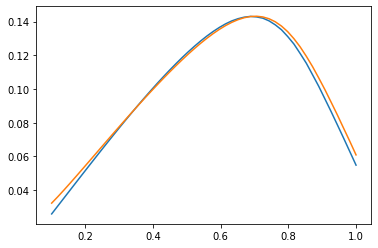

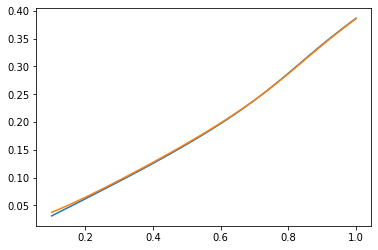

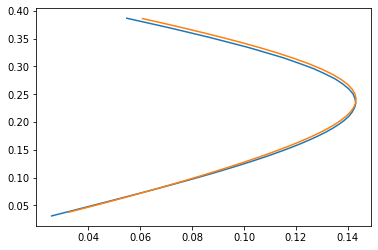

In [2]:
res_eqs.j,res_eqs.k=5,2
res_eqs.m1=5e-4
res_eqs.m2=5e-4
acrfn=acr_function(res_eqs.j,res_eqs.k)

ts = np.linspace(0.1,1)
e1a,e2a = np.zeros((2,len(ts)))
e1n,e2n = np.zeros((2,len(ts)))
for i,t in enumerate(ts):
    e1a[i],e2a[i] = acrfn(res_eqs.m2/res_eqs.m1,t)
    x0 = res_eqs.orbels_to_dyvars((res_eqs.alpha,e1a[i],0,1,e2a[i],np.pi))
    x0[0]=np.pi/2
    x0[1]=-np.pi/2
    eq = res_eqs.find_conservative_equilibrium(x0)
    _,e1n[i],_,_,e2n[i],_ = res_eqs.dyvars_to_orbels(eq)
plt.figure()
plt.plot(ts,e1a)
plt.plot(ts,e1n)
plt.figure()
plt.plot(ts,e2a)
plt.plot(ts,e2n)

plt.figure()
plt.plot(e1a,e2a)
plt.plot(e1n,e2n)

In [3]:
N=128
X = np.exp(1j * 2 * np.linspace(0,2*np.pi,N))
freqs = np.fft.fftshift(np.fft.fftfreq(N)*N)
A = np.fft.fft(X)
amps = np.fft.fftshift(A)/N
for l in range(1,3):
    print("{:.0f} {:.2f} {:.2f}".format(freqs[N//2+l],np.abs(amps[N//2+l]),np.angle(amps[N//2+l])),end="\t")
    print("{:.0f} {:.2f} {:.2f}".format(freqs[N//2-l],np.abs(amps[N//2-l]),np.angle(amps[N//2+l])))


1 0.02 0.02	-1 0.01 0.02
2 1.00 0.05	-2 0.00 0.05


In [4]:
def mean_to_osculating_dyvars(self,Q,z,N = 256):
    r"""
    Apply perturbation theory to transfrom from the phase space coordiantes of the 
    averaged model to osculating phase space coordintates of the full phase space.

    Assumes that the transformation is being applied at the fixed point of the 
    averaged model.

    Arguemnts
    ---------
    Q : float or ndarry
        Value(s) of angle (lambda2-lambda1)/k at which to apply transformation.
        Equilibrium points of the averaged model correspond to orbits that are 
        periodic in Q in the full phase space.
    z : dynamical variables
        Dynamical variables of the averaged model:
            $\sigma_1,\sigma_2,I_1,I_2,AMD$
    N : int, optional 
        Number of Q points to evaluate functions at when performing Fourier 
        transformation. Default is 
            N=256
    """
    omega_syn = self.omega_syn(z)
    OmegaMtrx = getOmegaMatrix(2)
    Omega_del2H = self.H_flow_jac(z)[:-1,:-1]
    vals,S = np.linalg.eig(Omega_del2H)
    S = np.transpose([S.T[i] for i in (0,2,1,3)])
    s1 = (S.T @ OmegaMtrx @ S)[0,2]
    s2 = (S.T @ OmegaMtrx @ S)[1,3]
    S.T[0]*=1/np.sqrt(s1)
    S.T[2]*=1/np.sqrt(s1)
    S.T[1]*=1/np.sqrt(s2)
    S.T[3]*=1/np.sqrt(s2)
    Sinv = np.linalg.inv(S)

    Qarr = np.atleast_1d(Q) 
    dchi = np.zeros((4,len(Qarr)),dtype=complex)

    # Fill arrays for FFT
    Qs = np.linspace(0,2*np.pi,N)
    X = np.zeros((N,4),dtype=complex)

    gradHkep = self.gradHkep(z)
    domega_syn_dz = self.grad_omega_syn(z)[1:-1]
    domega_syn_dw = S.T @ domega_syn_dz

    for i,q in enumerate(Qs):
        gradHosc = self.gradHpert(q,z) + gradHkep
        X[i] = S.T @ (gradHosc)[1:-1]
        X[i] -= self.Hpert_osc(q,z) * domega_syn_dw/omega_syn

    omegas = +1*np.imag(np.diag(Sinv @ Omega_del2H @ S))[:2]
    for I in range(2):
        A = np.fft.fft(X[:,I])
        freqs = np.fft.fftshift(np.fft.fftfreq(N)*N)
        amps = np.fft.fftshift(A)/N
        for l in range(1,N//2 - 1):
            sig = -1j * self.k * amps[N//2+l] * np.exp(1j * freqs[N//2+l] * Qarr)  / (-l*omega_syn - self.k * omegas[I])
            sig +=-1j * self.k * amps[N//2-l] * np.exp(1j * freqs[N//2-l] * Qarr)  / (l*omega_syn - self.k * omegas[I])
            dchi[I] += sig
    dchi[2] = -1j * np.conjugate(dchi[0])
    dchi[3] = -1j * np.conjugate(dchi[1])

    # Get AMD correction
    s = (self.j - self.k) / self.k
    dAMD = np.array([self.Hpert_osc(q,z) for q in Qarr]) / omega_syn / (s+1/2)

    # Something fishy is going on with signs!?  
    #   Should be the case that d(sigma,I) = -1*(S @ OmegaMtrx @ dchi).T) 
    #   but this gives the angle coordinate corrections the wrong sign...
    dsigmaI = np.transpose(np.array([-1,-1,-1,-1]) * (S @ OmegaMtrx @ dchi).T)
    result = np.transpose(z + np.vstack((dsigmaI,dAMD)).T)
    result = np.real(result) # trim small imaginary parts cause by numerical errors
    if result.shape[1] == 1:
        return result.reshape(-1)
    return result


In [89]:
res_eqs.m1 = 1e-4
res_eqs.m2 = 1e-4
res_eqs.j = 5
res_eqs.k = 2
t0 = 0.5
acrfn=acr_function(res_eqs.j,res_eqs.k)
e1guess,e2guess = acrfn(res_eqs.m2/res_eqs.m1,t0)
x0 = res_eqs.orbels_to_dyvars((res_eqs.alpha,e1guess,0,1,e2guess,np.pi))
if res_eqs.k==2:
    x0[0] = np.pi/2
    x0[1] = 3 * np.pi/2
eq = res_eqs.find_conservative_equilibrium(x0)
# if res_eqs.k==2:
#     eq[0] = np.pi/2
#     eq[1] = 3 * np.pi/2


if False:
    res_eqs.m1 = 2e-3
    res_eqs.m2 = 2e-3
    eq = res_eqs.find_conservative_equilibrium(eq)

In [90]:
Tsec = np.max(2 * np.pi / np.imag(np.linalg.eigvals( res_eqs.H_flow_jac(eq)[:-1,:-1] ) ))
Tres = np.min(np.abs(2 * np.pi / np.imag(np.linalg.eigvals( res_eqs.H_flow_jac(eq)[:-1,:-1] ) )))

In [91]:
res_eqs.alpha

0.7113786608980126

Tsyn: 2.50	 Tres: 210.59 	 Tsec: 14720.16


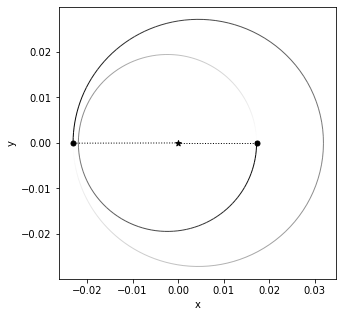

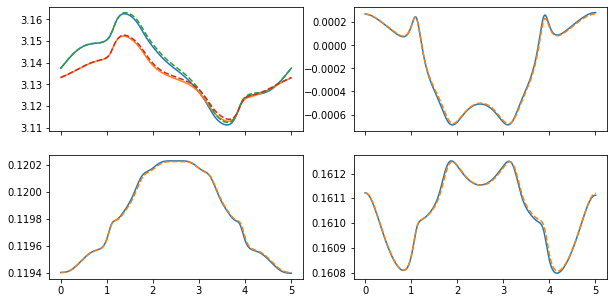

In [92]:
Q0=np.pi/2
sim,_ = res_eqs.dyvars_to_rebound_simulation(eq,Q=Q0,osculating_correction=True)
rb.OrbitPlot(sim,periastron=True)

ps=sim.particles
Tsyn = 2*np.pi / (ps[1].n - ps[2].n)
print("Tsyn: {:.2f}\t Tres: {:.2f} \t Tsec: {:.2f}".format(Tsyn,Tres,Tsec))
Ts = np.linspace(0,2*Tsyn,250)
e1 = np.zeros(len(Ts))
e2 = np.zeros(len(Ts))
theta1 = np.zeros(len(Ts))
theta2 = np.zeros(len(Ts))

alpha_n = np.zeros(len(Ts))
Qs_n = np.zeros(len(Ts))
for i,time in enumerate(Ts):
    sim.integrate(time)
    orbits = sim.calculate_orbits(jacobi_masses=True)
    e1[i] = orbits[0].e
    e2[i] = orbits[1].e
    alpha_n[i] = orbits[0].a / orbits[1].a
    phi = res_eqs.j * orbits[1].l - (res_eqs.j - res_eqs.k) * orbits[0].l
    theta1[i] = np.mod(phi - res_eqs.k*orbits[0].pomega + np.pi,2*np.pi)-np.pi
    theta2[i] = np.mod(phi - res_eqs.k*orbits[1].pomega ,2*np.pi)
    Qs_n[i] = np.mod(orbits[1].l - orbits[0].l ,2 *np.pi)
Qs_n = (np.unwrap(Qs_n))/res_eqs.k


fig,ax= plt.subplots(2,2,sharex=True,figsize=(10,5))


Qs = Q0 - Ts * np.pi / Tsyn
zcorr = res_eqs.mean_to_osculating_dyvars(
    Qs,
    eq
)
els_corr = np.array([res_eqs.dyvars_to_orbels(z) for z in zcorr.T])

ax[0,0].plot(Ts,np.mod(theta1,2*np.pi))
ax[0,0].plot(Ts,np.mod(theta2,2*np.pi))
ax[0,0].plot(Ts,els_corr.T[2],ls='--')
ax[0,0].plot(Ts,els_corr.T[5]-2*np.pi,ls='--')

ax[0,1].plot(Ts,alpha_n-res_eqs.alpha,ls='-')
ax[0,1].plot(Ts,els_corr.T[0]/els_corr.T[3] - res_eqs.alpha,ls='--')



ax[1,0].plot(Ts,e1,ls='-')
ax[1,0].plot(Ts,els_corr.T[1],ls='--')

ax[1,1].plot(Ts,e2,ls='-')
ax[1,1].plot(Ts,els_corr.T[4],ls='--')